In [1]:
# !pip install fasttext
# !pip install nltk
# !pip install memory_profiler
!pip install mkl

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


# Экспериментальная часть

In [2]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import Conc>eptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sys import getsizeof
from sys import getrefcount
import gc
import fasttext.util
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import random
import matplotlib.pyplot as plt
import memory_profiler

In [3]:
help(fasttext)

Help on package fasttext:

NAME
    fasttext

DESCRIPTION
    # Copyright (c) 2017-present, Facebook, Inc.
    # All rights reserved.
    #
    # This source code is licensed under the MIT license found in the
    # LICENSE file in the root directory of this source tree.

PACKAGE CONTENTS
    FastText
    tests (package)
    util (package)

DATA
    BOW = '<'
    EOS = '</s>'
    EOW = '>'
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...
    unicode_literals = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', ...

FILE
    /usr/local/lib/python3.6/dist-packages/fasttext/__init__.py




In [28]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [4]:
count_vect = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
tfidf_vect = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
porter_stemmer = nltk.stem.PorterStemmer()
tok = count_vect.build_tokenizer()
clf = LogisticRegression(solver='liblinear', C = 2.8, penalty = 'l1')
samples_number = 7

In [5]:
df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%Y-%m-%d")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all.label = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"
...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",Burned these in before listening to them for a...,5,Boom -- Pop -- Pow. These deliver.,1405555200,"07 17, 2014"
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",Some people like DJ style headphones or earbud...,5,"Thin and light, without compromising on sound ...",1405382400,"07 15, 2014"
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",I&#8217;m a big fan of the Brainwavz S1 (actua...,5,Same form factor and durability as the S1 with...,1405555200,"07 17, 2014"
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]","I've used theBrainwavz S1 In Ear Headphones, a...",5,Superb audio quality in a very comfortable set...,1405641600,"07 18, 2014"


In [31]:
df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
df_all["bin_label"] = df_all.overall > 3
# df_all["label"] = df_all.overall.apply(lambda x: '3' if x == 3 else ('1-2' if x < 3 else '4-5'))
df_all['label'] = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
0,A1ABVP0DV1ZN89,B00000JBAT,Adam Sacks,"[0, 0]",The RIO rocks! It is so great that Diamond Mul...,5,WOW! THE BEST THING TO HAPPEN TO MUSIC!,929232000,1999-06-13,True,3,the rio rock it is so great that diamond multi...
1,A6ILK3FXYH595,B00000J4FS,kc2kth,"[1, 1]",I have found a few places that will do memory ...,5,After-market Memory Upgrades,931132800,1999-07-05,True,3,have found few place that will do memori upgra...
2,A7RV1KU5O0II9,B00000JFMK,"David S. Saunders ""Equal parts tech geek, bra...","[0, 0]",I love this player! I travel frequently and th...,5,Incredible screen!,931392000,1999-07-08,True,3,love thi player travel frequent and the l50 ke...
3,AJ6TMOHHFJJAJ,B00000JMO4,Ali Navaie,"[5, 5]",If you are looking for the best camcorder in t...,5,Simply the best in the market --- Get it while...,932688000,1999-07-23,True,3,if you are look for the best camcord in the ma...
4,A1JTSRG8SU4VFO,B00000JFE3,L. Goff,"[0, 0]",The &quot;lip-synch&quot; problem has shown up...,5,Own the Sony 550D model,932688000,1999-07-23,True,3,the quot lip synch quot problem ha shown up on...
...,...,...,...,...,...,...,...,...,...,...,...,...
1689183,A9DH6MLZBGUMO,B00J8ZJCUW,Jules,"[0, 0]",I had to order two of these - The GLAZZ was so...,5,10 stars! The PERFECT protection for your iPad...,1406073600,2014-07-23,True,3,had to order two of these the glazz wa so well...
1689184,A1SLHNA3FV9U9E,B00HZVPD72,ashtangakasha,"[0, 0]","Tiny, simple, excellent sound quality, easy to...",4,"Tiny, simple, and effective.",1406073600,2014-07-23,True,3,tini simpl excel sound qualiti easi to set up ...
1689185,A2YQ9AX4GOTA0S,B00BOEG08M,NaN,"[0, 0]",Works great. Very convenient.,5,Five Stars,1406073600,2014-07-23,True,3,work great veri conveni
1689186,A2MUTLXDSV3JRC,B00IERCFFO,"MBW66 ""Pilcopata Man""","[0, 0]",Elegant trim case for iPad Air. No zipper case...,5,Slim case for iPad Air,1406073600,2014-07-23,True,3,eleg trim case for ipad air no zipper case for...


In [32]:
df_by_years = {}
for year in df_all.reviewTime.dt.year.unique().tolist():
    df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
    print(year, len(df_by_years[year]))
    print(df_by_years[year].bin_label.value_counts(), '\n')

1999 72
True     61
False    11
Name: bin_label, dtype: int64 

2000 817
True     686
False    131
Name: bin_label, dtype: int64 

2001 1609
True     1292
False     317
Name: bin_label, dtype: int64 

2002 2315
True     1802
False     513
Name: bin_label, dtype: int64 

2003 3547
True     2663
False     884
Name: bin_label, dtype: int64 

2004 5159
True     3655
False    1504
Name: bin_label, dtype: int64 

2005 9638
True     6994
False    2644
Name: bin_label, dtype: int64 

2006 15447
True     11528
False     3919
Name: bin_label, dtype: int64 

2007 35976
True     28404
False     7572
Name: bin_label, dtype: int64 

2008 49872
True     39460
False    10412
Name: bin_label, dtype: int64 

2009 70666
True     55304
False    15362
Name: bin_label, dtype: int64 

2010 103797
True     80475
False    23322
Name: bin_label, dtype: int64 

2011 173395
True     134860
False     38535
Name: bin_label, dtype: int64 

2012 282942
True     224559
False     58383
Name: bin_label, dtype: int64 

2

In [33]:
skf = StratifiedKFold(n_splits=samples_number)
data_by_year_splitted = {}
for year in range(2007, 2015):
    data_tmp = df_by_years[year].sample(35000)
    data_list, labels_list = [], []
    
    for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
        data = data_tmp.iloc[test_index]
        data_list.append(data.words)
        labels_list.append(data.label)
        
    data_by_year_splitted[year] = {'data': data_list, 'labels': labels_list}
    print(year)

2007
2008
2009
2010
2011
2012
2013
2014


In [34]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))
df_tvd = df_accuracy.copy()
df_js = df_accuracy.copy()
df_ks = df_accuracy.copy()
df_perc_no_zero = df_accuracy.copy()
df_accuracy_keras = df_accuracy.copy()
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [35]:
def generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [ ]:
for year_train in range(2007, 2015):
    for test_index in range(samples_number):
        print('step 1')
        vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        train_data = pd.Series(dtype=pd.StringDtype())
        train_labels = pd.Series(dtype=int)
        print('step 2')
        for train_index in range(samples_number):
            if test_index != train_index:
                train_data = train_data.append(data_by_year_splitted[year_train]['data'][train_index])
                train_labels = train_labels.append(data_by_year_splitted[year_train]['labels'][train_index])
        print('step 3')
        train_data = vecotrizer.fit_transform(train_data)
        print('step 4')
        input_dim = train_data.shape[1]
        model = Sequential()
        model.add(Dense(10, input_dim=input_dim, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        print('step 5')
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        print('step 6')
        batch_size = 32
        print('Start fitting')
        gen = generator(train_data.toarray(),to_categorical(train_labels), batch_size)
        model.fit(
                gen,
                epochs=3,
                steps_per_epoch = train_data.toarray().shape[0]/batch_size)
        print('Finish fitting')
        print('step 7')
        for year_test in range(year_train, 2015):
            test_data = vecotrizer.transform(data_by_year_splitted[year_test]['data'][test_index])
            test_labels = data_by_year_splitted[year_test]['labels'][test_index]
            
            loss, accuracy = model.evaluate(test_data.toarray(), to_categorical(test_labels), verbose=False)
            df_accuracy.loc[year_train][year_test][test_index] = accuracy
            
            dist_train = np.array(train_data.mean(axis=0))[0]
            dist_test = np.array(test_data.mean(axis=0))[0]
            tvd = sum(abs(dist_train - dist_test))/2
            js = jensenshannon(dist_train, dist_test)
            ks = ks_2samp(dist_train, dist_test).statistic
            perc_no_zero = np.count_nonzero(dist_test)/np.count_nonzero(dist_train)
            df_tvd.loc[year_train][year_test][test_index] = tvd
            df_js.loc[year_train][year_test][test_index] = js
            df_ks.loc[year_train][year_test][test_index] = ks
            df_perc_no_zero.loc[year_train][year_test][test_index] = perc_no_zero
            print("Train in {0}, test in {1}, test sample {2}\naccuracy_score = {3}, TVD = {4}, JS = {5}, KS = {6}".format(year_train, year_test, test_index, df_accuracy.loc[year_train][year_test][test_index], tvd, js, ks))
#             clear_session()
            del test_data
            del loss
            del accuracy
            gc.collect()
        print('step 8')
        clear_session()
        del model
        del train_data
        del gen
        gc.collect()
        print('step 9')
# df_accuracy = df_accuracy/samples_number
# df_accuracy[df_accuracy.eq(0)] = np.nan

step 1
step 2
step 3
step 4
step 5
step 6
Start fitting


### 3 метки

In [13]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [14]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,85.80%,85.66%,85.51%,84.71%,84.48%,85.61%,86.49%,86.93%
2008,,86.06%,85.55%,84.97%,84.67%,85.86%,86.61%,87.04%
2009,,,85.85%,84.91%,84.80%,85.83%,86.71%,87.03%
2010,,,,85.03%,84.82%,85.90%,86.83%,87.06%
2011,,,,,85.09%,86.22%,87.10%,87.36%
2012,,,,,,86.07%,86.83%,87.29%
2013,,,,,,,86.93%,87.01%
2014,,,,,,,,86.93%


In [15]:
df_mean_values(df_tvd)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.24,1.14,1.0,0.857,0.705,0.508,0.188,0.0864
2008,,1.18,1.09,0.948,0.777,0.524,0.132,0.0183
2009,,,1.15,1.05,0.86,0.564,0.118,0.0
2010,,,,1.18,1.07,0.78,0.325,0.2
2011,,,,,1.25,1.06,0.617,0.493
2012,,,,,,1.36,1.06,0.952
2013,,,,,,,1.55,1.52
2014,,,,,,,,1.59


In [16]:
df_mean_values(df_js)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.101,0.1,0.0939,0.0803,0.0629,0.0397,0.00906,0.0
2008,,0.101,0.0979,0.0859,0.0687,0.0449,0.0123,0.00282
2009,,,0.1,0.0917,0.0754,0.0513,0.017,0.00757
2010,,,,0.101,0.0893,0.0668,0.032,0.0222
2011,,,,,0.101,0.0836,0.0491,0.0394
2012,,,,,,0.101,0.0709,0.0618
2013,,,,,,,0.0999,0.0934
2014,,,,,,,,0.0995


In [25]:
df_mean_values(df_ks)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.173,0.18,0.178,0.159,0.132,0.0862,0.0201,0.00432
2008,,0.172,0.172,0.155,0.129,0.0829,0.0154,0.0
2009,,,0.173,0.158,0.133,0.0869,0.0183,0.00308
2010,,,,0.172,0.151,0.106,0.0364,0.0203
2011,,,,,0.173,0.132,0.0618,0.0448
2012,,,,,,0.175,0.107,0.0896
2013,,,,,,,0.18,0.164
2014,,,,,,,,0.18


In [18]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,90.984%,91.520%,91.417%,89.862%,87.392%,83.603%,76.130%,74.300%
2008,,90.962%,91.180%,89.709%,87.228%,83.323%,75.560%,73.696%
2009,,,90.950%,89.706%,87.339%,83.386%,75.427%,73.600%
2010,,,,90.994%,89.054%,85.508%,77.750%,75.907%
2011,,,,,90.959%,88.009%,80.794%,79.061%
2012,,,,,,90.947%,84.742%,83.210%
2013,,,,,,,90.994%,89.884%
2014,,,,,,,,90.965%


## Сorrelation

In [19]:
def transform_df_to_arr(df):
    arr = df.to_numpy().reshape(7*8*8,)
    arr = arr[arr != 0]
    return(arr)

def search_correlation(df_1, df_2):
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.scatter(arr_1, arr_2)
    return(np.corrcoef(arr_1, arr_2)[0, 1])

0.27828746065558424

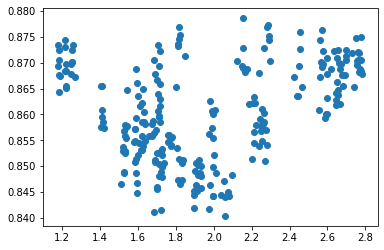

In [20]:
search_correlation(df_tvd, df_accuracy)

0.4571895369589027

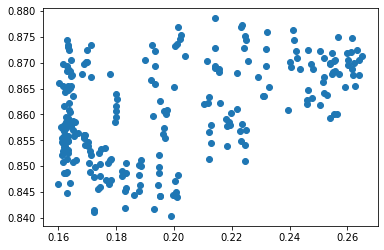

In [21]:
search_correlation(df_js, df_accuracy)

0.5313533209398367

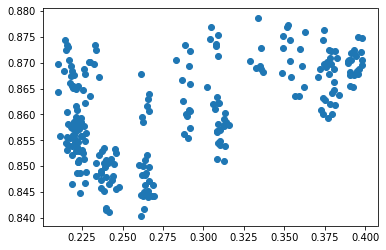

In [22]:
search_correlation(df_ks, df_accuracy)

-0.5527117326338793

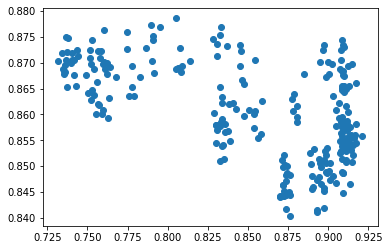

In [23]:
search_correlation(df_perc_no_zero, df_accuracy)